# Download forced photometry lightcurves from DB

Columns to be used:
- For epoch: `mjd`
- For filter: `filter` (g, r, i) or `fid` (1, 2, 3)
- For apparent magnitude: `mag_tot`
- For apparent magnitude uncertainty: `sigma_mag_tot_resc`
- For difference magnitude: `mag_diff`, sign of difference given by `isdiffpos`
- For difference magnitude uncertainty: `sigma_mag_diff_resc`
- For total flux in uJy: `flux_tot_uJy`
- For total flux uncertainty in uJy: `fluxunc_tot_uJy_resc`
- For difference flux in uJy: `flux_diff_uJy`
- For difference flux uncertainty in uJy: `sigma_flux_diff_uJy_resc`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import json
from astropy.time import Time
from config import db_credentials

In [2]:
conn = psycopg2.connect(
    host=db_credentials['host'],
    port=db_credentials['port'],
    user=db_credentials['user'],
    password=db_credentials['password'],
    database=db_credentials['database']
)

## Available classes:

In [3]:
available_classes = pd.read_sql(
    "SELECT DISTINCT alerceclass FROM object;",
    conn
)
available_classes

/tmp/ipykernel_36540/462451200.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  available_classes = pd.read_sql(


,alerceclass
0,SNIIn
1,DSCT
2,RRLc
3,AGN
4,YSO
5,TDE
6,CVNova
7,Microlensing
8,SNIIb
9,EA


## Small sample

In [4]:
selected_classes = [
    'SNIa',
    'RRLab'
]

In [5]:
objects_df = pd.read_sql(
    '''
    SELECT * 
    FROM object 
    WHERE alerceclass in (%s)
    ORDER BY ra
    LIMIT 10;
    ''' % ','.join(["'%s'" % alerce_class for alerce_class in selected_classes]),
    conn
)
objects_df

/tmp/ipykernel_36540/2375400149.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objects_df = pd.read_sql(


,oid,ra,dec,submitter,alerceclass
0,ZTF21abhkeak,0.043145,38.405438,amunoz,SNIa
1,ZTF17aaaxaql,0.279444,58.551623,amunoz,RRLab
2,ZTF19acklbjr,0.340099,34.607733,amunoz,SNIa
3,ZTF18abcbwod,0.508174,70.722246,amunoz,RRLab
4,ZTF17aaagril,0.613101,53.865761,amunoz,RRLab
5,ZTF20abgbxfm,0.650001,23.151748,amunoz,SNIa
6,ZTF20abyxnjo,0.690350,45.114823,amunoz,SNIa
7,ZTF20achstwk,0.818965,2.252151,amunoz,SNIa
8,ZTF17aaagrkk,0.869987,57.562138,amunoz,RRLab
9,ZTF20abupbub,1.027003,51.663960,amunoz,SNIa


### Full sample

In [6]:
objects_df = pd.read_sql(
    '''
    SELECT * 
    FROM object
    ''',
    conn
)
objects_df

/tmp/ipykernel_36540/4165438931.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objects_df = pd.read_sql(


,oid,ra,dec,submitter,alerceclass
0,ZTF20aczkcex,64.172486,-21.906687,amunoz,Periodic-Other
1,ZTF21aadkzap,178.900778,-20.927977,amunoz,Periodic-Other
2,ZTF20acuxzdo,338.589769,24.949044,amunoz,Periodic-Other
3,ZTF20actrbqz,139.090008,-21.435943,amunoz,Periodic-Other
4,ZTF20aawgszj,228.356961,-22.869290,amunoz,Periodic-Other
...,...,...,...,...,...
18719,ZTF21aaphvyi,197.128161,16.124974,amunoz,SNIa
18720,ZTF19abcncdg,226.876330,-5.456702,amunoz,SNIa
18721,ZTF19abmzord,335.769456,-3.015383,amunoz,SNIa
18722,ZTF21aatnxwt,164.948823,-7.007728,amunoz,SNIa


## Select the 'processed columns' that you want
The full list is:

'oid', 'index', 'mjd', 'nearestrefflux', 'flux_tot', 'flux_diff_ujy',
'sigma_flux_diff_ujy', 'flux_tot_ujy', 'fluxunc_tot', 'snr_tot',
'fluxunc_tot_ujy', 'mag_tot', 'sigma_mag_tot', 'mag_diff',
'sigma_mag_diff', 'isdiffpos', 'fid', 'secz', 'ccdquadid', 'zpthres',
'crit1', 'crit4', 'flag_bad', 'forcediffimfluxunc_resc',
'sigma_flux_diff_ujy_resc', 'fluxunc_tot_resc', 'fluxunc_tot_ujy_resc',
'snr_tot_resc', 'sigma_mag_diff_resc', 'sigma_mag_tot_resc'

'index' can be useful to match an 'original' observation with its corresponding processed version

In [7]:
processed_oids = pd.read_sql(
    '''
    SELECT DISTINCT oid
    FROM processed
    ''',
    conn
)
processed_oids

/tmp/ipykernel_36540/81217120.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  processed_oids = pd.read_sql(


,oid
0,ZTF18aaadfyl
1,ZTF21aaiaqhh
2,ZTF21aapjqdl
3,ZTF18aalozvy
4,ZTF18abcjabg
...,...
18712,ZTF23aaqniyk
18713,ZTF19abpfljz
18714,ZTF19aayepvi
18715,ZTF22aahjcmv


In [8]:
objects_df.set_index('oid', inplace=True)
objects_df.head()

,ra,dec,submitter,alerceclass
oid,,,,
ZTF20aczkcex,64.172486,-21.906687,amunoz,Periodic-Other
ZTF21aadkzap,178.900778,-20.927977,amunoz,Periodic-Other
ZTF20acuxzdo,338.589769,24.949044,amunoz,Periodic-Other
ZTF20actrbqz,139.090008,-21.435943,amunoz,Periodic-Other
ZTF20aawgszj,228.356961,-22.869290,amunoz,Periodic-Other


In [9]:
objects_df = objects_df.loc[processed_oids.values.flatten()]
objects_df.head()

,ra,dec,submitter,alerceclass
oid,,,,
ZTF18aaadfyl,156.578799,18.586220,amunoz,RSCVn
ZTF21aaiaqhh,193.878339,30.027998,amunoz,SNII
ZTF21aapjqdl,206.288918,-10.600883,amunoz,SNIa
ZTF18aalozvy,149.874570,21.389226,amunoz,Blazar
ZTF18abcjabg,283.041552,-3.028178,amunoz,CEP


In [10]:
lightcurves = pd.read_sql(
    '''
    SELECT oid, index, mjd, fid, mag_tot, sigma_mag_tot, flux_diff_ujy, sigma_flux_diff_ujy, detected
    FROM processed
    WHERE oid in (%s)
    ''' % ','.join(["'%s'" % oid for oid in objects_df.index.values]),
    conn
)
lightcurves

/tmp/ipykernel_36540/2126926833.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  lightcurves = pd.read_sql(


,oid,index,mjd,fid,mag_tot,sigma_mag_tot,flux_diff_ujy,sigma_flux_diff_ujy,detected
0,ZTF17aaaaajz,5,58303.480729,2,16.676931,0.012178,-71.579622,8.691542,True
1,ZTF17aaaaajz,6,58304.481157,1,19.897165,0.286292,-2.664656,10.525254,False
2,ZTF17aaaaajz,7,58305.481690,1,19.678274,0.250976,6.250977,11.287896,False
3,ZTF17aaaaajz,9,58307.469630,1,19.897145,0.148915,-2.663910,5.474830,False
4,ZTF17aaaaajz,10,58312.483380,1,19.841700,0.164991,-0.572602,6.383689,False
...,...,...,...,...,...,...,...,...,...
15194124,ZTF23abngbvw,1669,60249.402512,2,NaN,NaN,-13585.500946,-13585.500946,False
15194125,ZTF23abngbvw,1671,60251.358391,1,17.508996,0.017062,348.515807,5.658605,True
15194126,ZTF23abngbvw,1673,60251.415486,2,NaN,NaN,-11284.326851,-11284.326851,False
15194127,ZTF23abngbvw,1674,60253.311748,2,NaN,NaN,-11711.045196,-11711.045196,False


## Let's do some plots

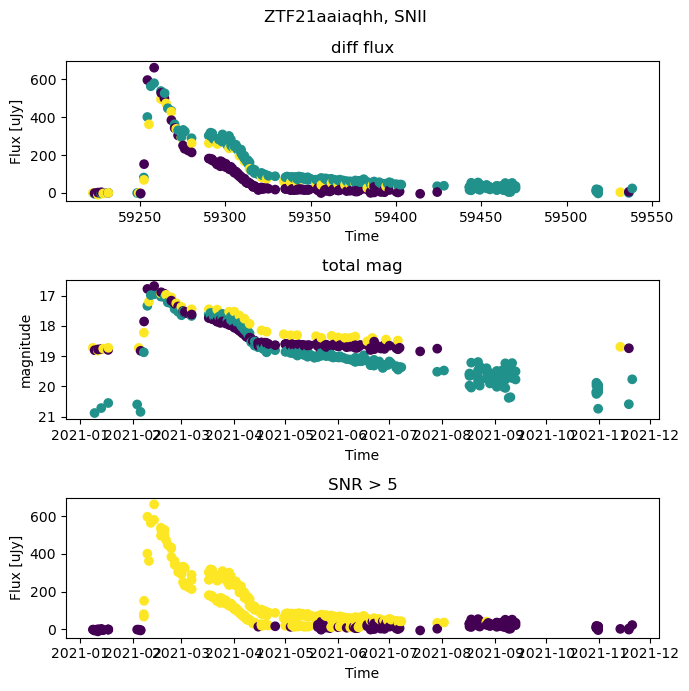

In [11]:
oid = objects_df.index.values[1]
lc = lightcurves[lightcurves.oid == oid]

fig = plt.figure(figsize=(7, 7))
fig.set_facecolor('white')
plt.suptitle(f'{oid}, {objects_df.loc[oid].alerceclass}')

time = Time(lc.mjd, format='mjd')

plt.subplot(3, 1, 1)
plt.scatter(lc.mjd, lc.flux_diff_ujy, c=lc.fid)
plt.xlabel('Time')
plt.ylabel('Flux [uJy]')
plt.title('diff flux')

plt.subplot(3, 1, 2)
plt.scatter(time.to_datetime(), lc.mag_tot, c=lc.fid)
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('magnitude')
plt.title('total mag')

plt.subplot(3, 1, 3)
plt.scatter(time.to_datetime(), lc.flux_diff_ujy, 
            c=(np.abs(lc.flux_diff_ujy / lc.sigma_flux_diff_ujy) > 5).astype(int))
plt.xlabel('Time')
plt.ylabel('Flux [uJy]')
plt.title('SNR > 5')

plt.tight_layout()

## Please save the lightcurves and object info to avoid downloading data from AWS over and over

In [ ]:
len(lightcurves)

In [ ]:
!ls

In [12]:
lightcurves.to_parquet('lightcurves_231128.parquet')

In [13]:
objects_df.to_parquet('objects_231128.parquet')

## Lightcurve analysis (nan)

In [14]:
lightcurves.isna().mean(axis=0)

oid                    0.000000
index                  0.000000
mjd                    0.000000
fid                    0.000000
mag_tot                0.081841
sigma_mag_tot          0.068554
flux_diff_ujy          0.000000
sigma_flux_diff_ujy    0.000000
detected               0.000000
dtype: float64